<a href="https://colab.research.google.com/github/Gabriel-Amarante/Vision-Computing/blob/main/QUIZ_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import e

In [ ]:
img = cv2.imread("carro.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
# Tirando a imagem do dominio espacial para o dominio da frequencia
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
magnitude_spectrum = np.log(cv2.magnitude(dft[:,:,0],dft[:,:,1]))

In [ ]:
def butterworth(u, v, cr, cc, D0, n):
    tmp = 1 / (1+(np.sqrt((u - cr) ** 2 + (v - cc) ** 2) / D0) ** (2 * n))
    return tmp

In [ ]:
N,M = 640, 480
cr, cc = M // 2, N // 2 # Spectrum center 
H2 = np.zeros((M,N), dtype=float)
for u in range(M):
    for v in range(N):
        H2[u,v] = butterworth(u,v,cr,cc,30,2)

# Transformando a Matriz H2 em uma matriz coluna H        
H = H2.flatten()

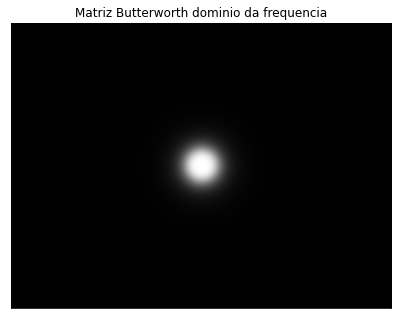

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(121),plt.imshow(H2 , cmap ='gray')
plt.title('Matriz Butterworth dominio da frequencia'),plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
def transfor_C(u, v, x, y, M, N):
    c = e**(-2j*np.pi*(((x*u)/M)+((y*v)/N)))
    return c   

A mascara C fora obtida usando a equação $\hat{H}(u, v)=\frac{1}{M N} \sum_{x=0}^{m-1} \sum_{y=0}^{n-1} \hat{h}(x, y) e^{-i 2 \pi\left(\frac{x u}{M}+\frac{y v}{N}\right)}$ empregando a relação $[\hat{H}]=[C][\widehat{h}]$, portanto, podemos relacionar a matrix C com a seguinte equação $C=\frac{1}{M N} \sum_{x=0}^{m-1} \sum_{y=0}^{n-1} e^{-i 2 \pi\left(\frac{x u}{M}+\frac{y v}{N}\right)}$, onde os valores de x e y percorrem toda a imagem juntamente com os valores de u e v que vão até M-1 e N-1, respectivamente, dessa forma obtemos uma matriz de tensores que será usada para conseguir os valores de $\widehat{h}$, com ele em mãos, podemos usar para fazer a convolução com as imagens que foram acrescentadas ruídos no inicio. As dimensões de C será $NM\times 25$, onde N e M assumem os valores da dimensões da imagem escolhida a priori.

In [ ]:
C = []
for x in range(M):
    for y in range(N):
        MN = []
        for u in range(5):
            for v in range(5):
                MN.append(transfor_C(u,v,x,y,M,N))
        C.append(MN)
C = np.array(C)
C = C/(M*N)


In [ ]:
h_hat = np.matmul(np.linalg.pinv(C),H)
h_hat = np.resize(h_hat,(5,5)) 

In [ ]:
imag_com_ruido_1 = img + np.random.normal(0,0.1,size=[M,N])
imag_com_ruido_2 = img + np.random.normal(0,0.2,size=[M,N])
imag_com_ruido_3 = img + np.random.normal(0,0.3,size=[M,N])

In [ ]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.         251.0912172  ... 236.85699051   0.
    0.        ]
 ...
 [  0.           0.          88.70862678 ... 108.19385654   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.         251.29829611 ... 237.06394034   0.
    0.        ]
 ...
 [  0.           0.          88.96331531 ... 107.92585505   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.         251.06531238 ... 237.40264194   0.
    0.        ]
 ...
 [  0.           0.          89.34730042 ... 108.32883709   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


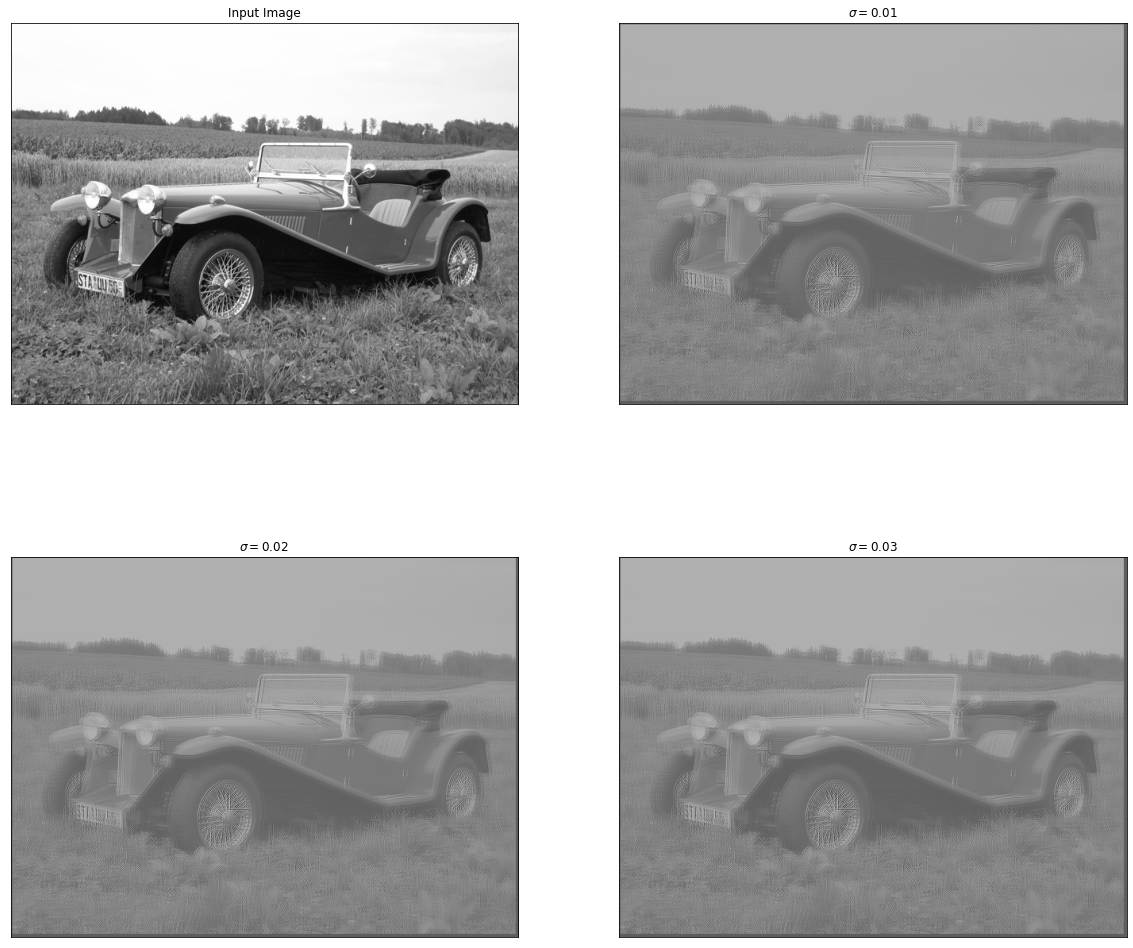

In [ ]:
if __name__ == '__main__':

    # Convolve and Save Output
    output = convolve2D(imag_com_ruido_1, h_hat, padding=2)
    output1 = convolve2D(imag_com_ruido_2, h_hat, padding=2)
    output2 = convolve2D(imag_com_ruido_3, h_hat, padding=2)
    
    plt.figure(figsize=(20, 18))
    plt.subplot(221),plt.imshow(img, cmap ='gray')
    plt.title('Input Image'),plt.xticks([]), plt.yticks([])
    plt.subplot(222),plt.imshow(output, cmap ='gray')
    plt.title(r'$\sigma = 0.01$'),plt.xticks([]), plt.yticks([])
    plt.subplot(223),plt.imshow(output1, cmap ='gray')
    plt.title(r'$\sigma = 0.02$'),plt.xticks([]), plt.yticks([])
    plt.subplot(224),plt.imshow(output2, cmap ='gray')
    plt.title(r'$\sigma = 0.03$'),plt.xticks([]), plt.yticks([])

    plt.show()

In [ ]:
img2 = cv2.imread("ind2.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. 255. ... 255.   0.   0.]
 ...
 [  0.   0. 255. ... 255.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


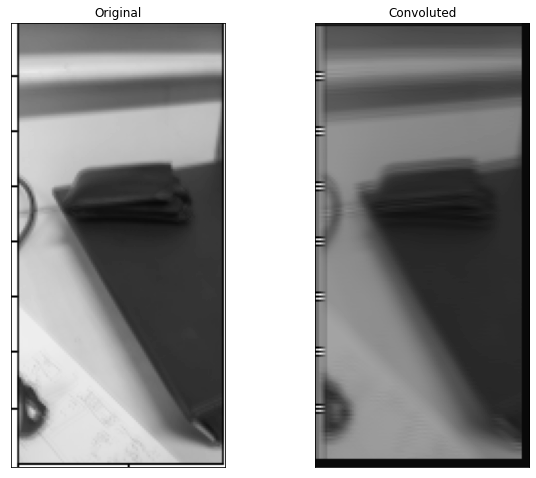

In [ ]:
if __name__ == '__main__':

    # Convolve and Save Output
    output3 = convolve2D(img2, h, padding=2)

    plt.figure(figsize=(10, 18))
    plt.subplot(221),plt.imshow(img2, cmap ='gray')
    plt.title('Original'),plt.xticks([]), plt.yticks([])
    plt.subplot(222),plt.imshow(output3, cmap ='gray')
    plt.title('Convoluted'),plt.xticks([]), plt.yticks([])

    plt.show()